In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'emotion'
values = df[TARGET_COLUMN].unique().tolist()
values

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([373, 369, 189, 374, 373, 185, 374, 192]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1449, 231)
Val: (363, 231)
Test: (617, 231)


### Default plots

In [7]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            embedding=None, n_pts=30, 
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = predictor.predict(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=len(np.unique(y))-1)
    plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    plt.legend()
    plt.axis("off");
    plt.title(title);   

now prepare an  so it saves time

In [8]:
# from umap import UMAP

# reducer = UMAP(n_neighbors=20)
# embedding = reducer.fit_transform(X)

from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(X)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix")
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False, ax=ax)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    
    plt.savefig(f"images/{title.replace(" ", "_")}.pdf")

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-08 13:56:17,783] A new study created in memory with name: no-name-7a4f0330-c0f2-4c6b-8c9b-8ca15c9aa866
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[W 2023-07-08 13:56:17,794] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 7.783445997928208, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", lin

[W 2023-07-08 13:56:21,879] Trial 10 failed with parameters: {'penalty': 'elasticnet', 'C': 7.5350883013042536, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only '

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-07-08 13:56:31,588] Trial 20 finished with value: 0.5564738292011019 and parameters: {'penalty': 'none', 'C': 3.930027599651206, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5647382920110193.
[W 2023-07-08 13:56:31,604] Trial 21 failed with parameters: {'penalty': 'l1', 'C': 8.912859158088247, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.").
Trace

[W 2023-07-08 13:56:39,644] Trial 29 failed with value None.
[W 2023-07-08 13:56:39,722] Trial 30 failed with parameters: {'penalty': 'elasticnet', 'C': 9.159636586079408, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:39,996] Trial 37 failed with value None.
[W 2023-07-08 13:56:40,044] Trial 38 failed with parameters: {'penalty': 'elasticnet', 'C': 9.430068917138419, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:40,581] Trial 45 failed with value None.
[W 2023-07-08 13:56:40,646] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 9.709917224929608, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

[W 2023-07-08 13:56:41,207] Trial 53 failed with value None.
[W 2023-07-08 13:56:41,251] Trial 54 failed with parameters: {'penalty': 'elasticnet', 'C': 9.872228614631014, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:41,748] Trial 61 failed with value None.
[W 2023-07-08 13:56:41,777] Trial 62 failed with parameters: {'penalty': 'elasticnet', 'C': 9.905893401592175, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:42,080] Trial 69 failed with value None.
[W 2023-07-08 13:56:42,131] Trial 70 failed with parameters: {'penalty': 'elasticnet', 'C': 9.862279547947102, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:42,517] Trial 77 failed with value None.
[W 2023-07-08 13:56:42,555] Trial 78 failed with parameters: {'penalty': 'l1', 'C': 9.553592145019692, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

[W 2023-07-08 13:56:42,998] Trial 85 failed with value None.
[W 2023-07-08 13:56:43,052] Trial 86 failed with parameters: {'penalty': 'l1', 'C': 9.542672195172646, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

[W 2023-07-08 13:56:43,468] Trial 93 failed with value None.
[W 2023-07-08 13:56:43,514] Trial 94 failed with parameters: {'penalty': 'elasticnet', 'C': 9.904238018902612, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 13:56:43,892] Trial 101 failed with value None.
[W 2023-07-08 13:56:43,939] Trial 102 failed with parameters: {'penalty': 'elasticnet', 'C': 9.697402329581529, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-08 13:56:44,435] Trial 109 failed with value None.
[W 2023-07-08 13:56:44,485] Trial 110 failed with parameters: {'penalty': 'elasticnet', 'C': 9.109858994343318, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-08 13:56:44,939] Trial 117 failed with value None.
[W 2023-07-08 13:56:44,984] Trial 118 failed with parameters: {'penalty': 'elasticnet', 'C': 9.046071972016827, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-08 13:56:45,532] Trial 125 failed with value None.
[W 2023-07-08 13:56:45,563] Trial 126 failed with parameters: {'penalty': 'elasticnet', 'C': 9.567057632267447, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-08 13:56:45,799] Trial 133 failed with value None.
[W 2023-07-08 13:56:45,835] Trial 134 failed with parameters: {'penalty': 'l1', 'C': 8.110285597776974, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError

[W 2023-07-08 13:56:46,352] Trial 141 failed with value None.
[W 2023-07-08 13:56:46,405] Trial 142 failed with parameters: {'penalty': 'l1', 'C': 9.24728363399413, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError:

[W 2023-07-08 13:56:46,942] Trial 149 failed with value None.
[I 2023-07-08 13:57:04,779] Trial 11 finished with value: 0.5426997245179064 and parameters: {'penalty': 'l1', 'C': 6.239939473108199, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5647382920110193.
[I 2023-07-08 13:57:07,476] Trial 16 finished with value: 0.5399449035812672 and parameters: {'penalty': 'l1', 'C': 6.229067639768931, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5647382920110193.
[I 2023-07-08 13:57:26,316] Trial 23 finished with value: 0.5454545454545454 and parameters: {'penalty': 'l1', 'C': 9.935306481776557, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5647382920110193.


In [ ]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

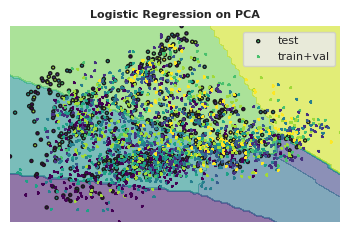

In [12]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title="Logistic Regression on PCA", 
                        cmap="viridis",
                       n_pts=80)
plt.savefig("images/LogRegUMAP.pdf")

In [ ]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix")

# Suppport Vector Machine

## Linear SVM

In [14]:
from sklearn.svm import LinearSVC

In [15]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 13:57:33,999] A new study created in memory with name: no-name-58ec3971-4a51-471c-92c5-8bbe107b7ccc
[W 2023-07-08 13:57:34,018] Trial 1 failed with parameters: {'penalty': 'l1', 'C': 77.92872071775828, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pyt

[W 2023-07-08 13:57:44,890] Trial 9 failed with value None.
[W 2023-07-08 13:57:44,926] Trial 10 failed with parameters: {'penalty': 'l1', 'C': 89.37720055540943, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-

[W 2023-07-08 13:57:45,965] Trial 17 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 13:57:55,950] Trial 11 finished with value: 0.5564738292011019 and parameters: {'penalty': 'l2', 'C': 13.232241053884712, 'loss': 'hinge'}. Best is trial 11 with value: 0.5564738292011019.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 13:57:57,618] Trial 12 finished with value: 0.5041322314049587 and parameters: {'penalty': 'l2', 'C': 40.73986711087145, 'loss': 'squared_hinge'}. Best is trial 11 with value: 0.5564738292011019.
[W 2023-07-08 13:57:57,629] Trial 20 failed with parameters: {'penalty': 'l1', 'C': 90.6475052492444, 'los

[W 2023-07-08 13:58:10,298] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 7.616884885468181, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-08 13:58:10,667] Trial 33 failed with value None.
[W 2023-07-08 13:58:10,712] Trial 34 failed with parameters: {'penalty': 'l1', 'C': 3.756708490176969, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 13:58:10,980] Trial 39 failed with value None.
[W 2023-07-08 13:58:10,983] Trial 40 failed with parameters: {'penalty': 'l1', 'C': 8.721313289917255, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 13:58:11,188] Trial 45 failed with value None.
[W 2023-07-08 13:58:11,187] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 8.79844046046955, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 122

[W 2023-07-08 13:58:11,448] Trial 51 failed with value None.
[W 2023-07-08 13:58:11,514] Trial 53 failed with parameters: {'penalty': 'l1', 'C': 10.715718731700541, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 13:58:11,668] Trial 57 failed with value None.
[W 2023-07-08 13:58:11,668] Trial 58 failed with parameters: {'penalty': 'l1', 'C': 8.208554814702065, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 13:58:11,843] Trial 63 failed with parameters: {'penalty': 'l1', 'C': 13.61052419029815, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-08 13:58:12,056] Trial 69 failed with value None.
[W 2023-07-08 13:58:12,082] Trial 71 failed with parameters: {'penalty': 'l1', 'C': 14.716200706937464, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 13:58:12,235] Trial 75 failed with value None.
[W 2023-07-08 13:58:12,229] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 8.995265012510252, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 13:58:12,491] Trial 82 failed with parameters: {'penalty': 'l1', 'C': 2.9949589692997574, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-08 13:58:12,686] Trial 87 failed with parameters: {'penalty': 'l1', 'C': 23.97531116475173, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-08 13:58:12,926] Trial 94 failed with value None.
[W 2023-07-08 13:58:12,924] Trial 93 failed with value None.
[W 2023-07-08 13:58:12,924] Trial 92 failed with parameters: {'penalty': 'l1', 'C': 17.920165774776052, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRm

[W 2023-07-08 13:58:13,103] Trial 98 failed with value None.
[W 2023-07-08 13:58:13,104] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 13.317520634047739, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-08 13:58:13,414] Trial 107 failed with parameters: {'penalty': 'l1', 'C': 14.888584206397645, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solv

[W 2023-07-08 13:58:13,537] Trial 109 failed with value None.
[W 2023-07-08 13:58:13,551] Trial 111 failed with value None.
[W 2023-07-08 13:58:13,618] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 12.865977302199774, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-Peq

[W 2023-07-08 13:58:13,841] Trial 117 failed with value None.
[W 2023-07-08 13:58:13,919] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 10.031532633608247, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line

[W 2023-07-08 13:58:14,129] Trial 123 failed with value None.
[W 2023-07-08 13:58:14,134] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 10.704484413682307, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line

[W 2023-07-08 13:58:14,330] Trial 130 failed with parameters: {'penalty': 'l1', 'C': 12.005242256126829, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solv

[W 2023-07-08 13:58:14,510] Trial 135 failed with value None.
[W 2023-07-08 13:58:14,575] Trial 136 failed with parameters: {'penalty': 'l1', 'C': 7.405467413636699, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-08 13:58:14,794] Trial 141 failed with value None.
[W 2023-07-08 13:58:14,798] Trial 140 failed with value None.
[W 2023-07-08 13:58:14,855] Trial 144 failed with parameters: {'penalty': 'l1', 'C': 14.524585694270195, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-Peq

[W 2023-07-08 13:58:15,023] Trial 147 failed with value None.
[W 2023-07-08 13:58:15,030] Trial 149 failed with parameters: {'penalty': 'l1', 'C': 14.847422783754155, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_118123/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line

In [16]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 13.232241053884712, 'loss': 'hinge'}
              precision    recall  f1-score   support

           0       0.54      0.74      0.62        96
           1       0.49      0.55      0.52        94
           2       0.43      0.53      0.48        45
           3       0.70      0.33      0.45        95
           4       0.35      0.44      0.39        96
           5       0.33      0.31      0.32        48
           6       0.40      0.26      0.32        95
           7       0.33      0.35      0.34        48

    accuracy                           0.45       617
   macro avg       0.45      0.44      0.43       617
weighted avg       0.47      0.45      0.44       617

Accuracy 0.44894651539708263
F1-score [0.62280702 0.51741294 0.47524752 0.44604317 0.38888889 0.32258065
 0.31847134 0.34343434]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


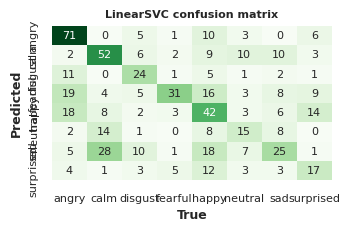

In [17]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('LinearSVC confusion matrix')

ticks = np.unique(y)
ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))

plt.savefig("images/LinearSVC_conf_matrix.pdf")

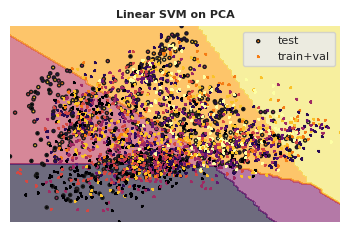

In [18]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title="Linear SVM on PCA", 
                        cmap="inferno",
                       n_pts=80)
plt.savefig("images/linear_SVM_UMAP.pdf")

In [20]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [ ]:
# Plots the decision function for diferent values of C
for i, C in enumerate([0.02, 300]):
    plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

    cmap="viridis"
    clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

    # Genearate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = clf.decision_function(points_in_gigaspace)
    mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
    plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
    # Plot support
    results = clf.decision_function(X_train)
    support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
    plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
    plt.axis("off")
#     decision_function = clf.decision_function(X_res_t)
# #     we can also calculate the decision function manually
# #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
#     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
#     support_vectors = X_res_t[support_vector_indices]
#     support_vectors_pca = pca.transform(support_vectors)

#     plt.subplot(1, 2, i + 1)
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
#     ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
#     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
#                          np.linspace(ylim[0], ylim[1], 50))
#     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
#     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#                 linestyles=['--', '-', '--'])
#     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
#                 linewidth=1, facecolors='none', edgecolors='k')
#     plt.title("C=" + str(C))
#     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# plt.tight_layout()
# plt.show()
    plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
    plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [21]:
from sklearn.svm import SVC

In [22]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_train, y_train)
    y_pred = lin_svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 13:58:55,353] A new study created in memory with name: no-name-bea899fb-8097-4fbb-8a5e-30f2878ee17d
[I 2023-07-08 13:58:56,341] Trial 2 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 37.68714479288209, 'gamma': 0.23855585814096647}. Best is trial 2 with value: 0.6446280991735537.
[I 2023-07-08 13:58:56,352] Trial 0 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 58.12690707686507, 'gamma': 0.7709585424049129}. Best is trial 2 with value: 0.6446280991735537.
[I 2023-07-08 13:58:56,524] Trial 1 finished with value: 0.42699724517906334 and parameters: {'kernel': 'sigmoid', 'C': 6.275029475769968, 'gamma': 0.0045922863901682355}. Best is trial 2 with value: 0.6446280991735537.
[I 2023-07-08 13:58:56,647] Trial 3 finished with value: 0.14325068870523416 and parameters: {'kernel': 'sigmoid', 'C': 70.51230461980771, 'gamma': 0.6318992791161503}. Best is trial 2 with value: 0.6446280991735537.
[I 2023-07-08 13:58:57

[I 2023-07-08 13:59:13,652] Trial 39 finished with value: 0.5895316804407713 and parameters: {'kernel': 'poly', 'C': 3.718131647174685, 'gamma': 0.02945094531431905}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:13,904] Trial 38 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 18.908768657876884, 'gamma': 0.28273618094932956}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:14,375] Trial 40 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 3.8463862945182488, 'gamma': 0.28547734480330944}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:14,603] Trial 41 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 26.43891083980179, 'gamma': 0.2814553561302254}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:15,823] Trial 42 finished with value: 0.6914600550964187 and parameters: {'kernel': 'rbf', 'C': 25.55314446769473, 

[I 2023-07-08 13:59:31,837] Trial 77 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 16.882779655153804, 'gamma': 0.19868340711739949}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:31,890] Trial 76 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 16.649270083908238, 'gamma': 0.1949909873210412}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:32,657] Trial 78 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 17.585420484629825, 'gamma': 0.2049863177609148}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:33,533] Trial 79 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 16.959538593884524, 'gamma': 0.20993642517952596}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:34,185] Trial 81 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 23.062697678287563, 'ga

[I 2023-07-08 13:59:51,184] Trial 115 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 26.574737641217958, 'gamma': 0.3072193731161135}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:51,618] Trial 116 finished with value: 0.696969696969697 and parameters: {'kernel': 'rbf', 'C': 28.375477237719906, 'gamma': 0.31388348040451536}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:51,931] Trial 117 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 28.34273641470564, 'gamma': 0.30674873247875045}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:52,811] Trial 118 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 22.735292682052094, 'gamma': 0.3059599566607387}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 13:59:53,133] Trial 119 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 13.137875190198567, 

[I 2023-07-08 14:00:11,152] Trial 154 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 19.935975668575736, 'gamma': 0.21166597952555283}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:11,221] Trial 153 finished with value: 0.696969696969697 and parameters: {'kernel': 'rbf', 'C': 19.876055428380194, 'gamma': 0.24330803585793007}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:11,405] Trial 155 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 19.929959246997214, 'gamma': 0.23948626684787144}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:12,098] Trial 156 finished with value: 0.696969696969697 and parameters: {'kernel': 'rbf', 'C': 20.441629027935164, 'gamma': 0.24238355132210027}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:13,387] Trial 158 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 13.677789254390962,

[I 2023-07-08 14:00:31,232] Trial 191 finished with value: 0.14325068870523416 and parameters: {'kernel': 'sigmoid', 'C': 16.509000269578646, 'gamma': 0.4718985899175692}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:31,594] Trial 190 finished with value: 0.14325068870523416 and parameters: {'kernel': 'sigmoid', 'C': 15.999231333941736, 'gamma': 0.25386734365909164}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:31,658] Trial 193 finished with value: 0.6446280991735537 and parameters: {'kernel': 'poly', 'C': 16.040135883107503, 'gamma': 0.14477444880153462}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:33,194] Trial 194 finished with value: 0.6942148760330579 and parameters: {'kernel': 'rbf', 'C': 26.59353421978613, 'gamma': 0.32677857597518056}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:33,346] Trial 195 finished with value: 0.696969696969697 and parameters: {'kernel': 'rbf', 'C': 26.9205

[I 2023-07-08 14:00:51,437] Trial 229 finished with value: 0.6859504132231405 and parameters: {'kernel': 'rbf', 'C': 20.580238606793145, 'gamma': 0.42713676729420164}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:51,740] Trial 230 finished with value: 0.7024793388429752 and parameters: {'kernel': 'rbf', 'C': 30.6284501603213, 'gamma': 0.2275642901259896}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:52,325] Trial 231 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 15.798103197189718, 'gamma': 0.219694490980251}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:52,732] Trial 232 finished with value: 0.6859504132231405 and parameters: {'kernel': 'rbf', 'C': 6.861975617661389, 'gamma': 0.15325405292480573}. Best is trial 34 with value: 0.7024793388429752.
[I 2023-07-08 14:00:53,388] Trial 233 finished with value: 0.699724517906336 and parameters: {'kernel': 'rbf', 'C': 15.694619888800952, 'ga

In [23]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 17.90982807395262, 'gamma': 0.1965402929355844}
              precision    recall  f1-score   support

           0       0.48      0.72      0.57        96
           1       0.54      0.45      0.49        94
           2       0.50      0.51      0.51        45
           3       0.49      0.39      0.43        95
           4       0.39      0.48      0.43        96
           5       0.38      0.38      0.38        48
           6       0.37      0.27      0.32        95
           7       0.42      0.33      0.37        48

    accuracy                           0.45       617
   macro avg       0.45      0.44      0.44       617
weighted avg       0.45      0.45      0.44       617

Accuracy 0.44894651539708263
F1-score [0.575      0.48837209 0.50549451 0.43274854 0.43192488 0.375
 0.31515152 0.37209302]


In [24]:
print(svc.support_vectors_.shape)
print(X.shape)

(1662, 231)
(2429, 231)


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


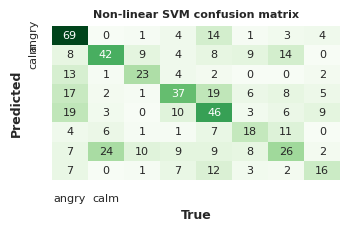

In [25]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g", ax=ax)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Non-linear SVM confusion matrix')

ax.set_xticks([0.5,1.5], labels=label_enc.inverse_transform([[0],[1]]))
ax.set_yticks([0.5,1.5], labels=label_enc.inverse_transform([[0],[1]]))

plt.savefig("images/nonlinear_svm_conf_matrix.pdf")
plt.show()

In [ ]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [ ]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [ ]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [ ]:
# support_vectors_pca = pca.transform(support_vectors)

In [ ]:
# for kernel in ('linear', 'rbf', 'poly'):
#     clf = SVC(kernel=kernel, gamma=0.1, C=26)
#     clf.fit(X_res_t, y_res_t)

#     plt.figure()
#     plt.clf()
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
#                 edgecolor='k', s=20)

#     # Circle out the test data
# #     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
# #                 zorder=10, edgecolor='k')

#     plt.axis('tight')
#     x_min = X_pca[:, 0].min()
#     x_max = X_pca[:, 0].max()
#     y_min = X_pca[:, 1].min()
#     y_max = X_pca[:, 1].max()

#     XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
#     clf.fit(X_pca, y_res_t)
#     Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(XX.shape)
#     plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
#     plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
#                 linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

#     plt.title(kernel)
# plt.show()

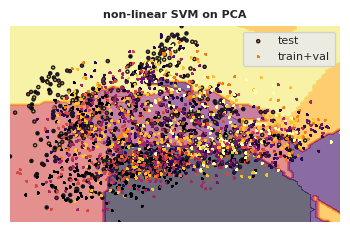

In [26]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title="non-linear SVM on PCA", 
                        cmap="inferno",
                        n_pts=80)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [27]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

2023-07-08 14:02:04.664684: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 14:02:05.362675: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 14:02:05.364894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 14:02:07.306713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
from scikeras.wrappers import KerasClassifier

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [31]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [ ]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 14:06:51,475] A new study created in memory with name: no-name-20fdebf5-5b1f-49c6-9c34-689477b381e9
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 4s 13ms/step - loss: 2.0547 - accuracy: 0.1622
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0410 - accuracy: 0.1863
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0292 - accuracy: 0.1974
Epoch 4/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0202 - accuracy: 0.1925
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 2.0131 - accuracy: 0.2188
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0057 - accuracy: 0.2381
Epoch 2/50
46/46 [==============================] - 7s 14ms/step - loss: 2.0523 - accuracy: 0.1712
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0466 - accuracy: 0.1532
Epoch 3/50
 4/46 [=>............................] - ETA: 0s - loss: 2.0329 - accuracy: 0.1641Epoch 8/50
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss:

Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3482 - accuracy: 0.4762
Epoch 15/50
46/46 [==============================] - 1s 16ms/step - loss: 1.6151 - accuracy: 0.3313
Epoch 17/50
46/46 [==============================] - 1s 17ms/step - loss: 1.8122 - accuracy: 0.2899
Epoch 23/50
46/46 [==============================] - 1s 14ms/step - loss: 1.6005 - accuracy: 0.3471
Epoch 18/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2962 - accuracy: 0.4796
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4364 - accuracy: 0.4168
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7837 - accuracy: 0.2947
Epoch 25/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2617 - accuracy: 0.4955
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4329 - accuracy: 0.4203
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 1.7719 - accuracy: 0.2954


Epoch 29/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2563 - accuracy: 0.5121
Epoch 29/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4972 - accuracy: 0.3754
Epoch 30/50
25/46 [===============>..............] - ETA: 0s - loss: 1.1645 - accuracy: 0.5412Epoch 30/50
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 1.1260 - accuracy: 0.5611
Epoch 31/50
46/46 [==============================] - 1s 14ms/step - loss: 1.4849 - accuracy: 0.3948
Epoch 32/50
46/46 [==============================] - 1s 11ms/step - loss: 1.6441 - accuracy: 0.3147
Epoch 39/50
46/46 [==============================] - 1s 16ms/step - loss: 1.2352 - accuracy: 0.5052
Epoch 32/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6380 - accuracy: 0.3292
Epoch 40/50
46/46 [==============================] - 1s 15ms/step - loss: 1.4546 - accuracy: 0.4113
Epoch 35/50
46/46 [==============================] - 1s 13ms/step - loss: 1.6322 - accuracy: 0

46/46 [==============================] - 1s 14ms/step - loss: 1.4011 - accuracy: 0.4362
Epoch 43/50
46/46 [==============================] - 1s 15ms/step - loss: 1.1108 - accuracy: 0.5493
Epoch 42/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3911 - accuracy: 0.4389
Epoch 44/50
46/46 [==============================] - 1s 13ms/step - loss: 1.1415 - accuracy: 0.5528
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 1.3818 - accuracy: 0.4348
Epoch 44/50


[I 2023-07-08 14:07:26,911] Trial 3 finished with value: 0.3746556473829201 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.3746556473829201.


43/46 [===========================>..] - ETA: 0s - loss: 1.1115 - accuracy: 0.5567

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 1.1303 - accuracy: 0.5452
Epoch 45/50
46/46 [==============================] - 1s 16ms/step - loss: 1.0313 - accuracy: 0.5942
Epoch 46/50
46/46 [==============================] - 1s 16ms/step - loss: 1.3761 - accuracy: 0.4438
Epoch 47/50
46/46 [==============================] - 1s 16ms/step - loss: 1.1195 - accuracy: 0.5480
Epoch 46/50
46/46 [==============================] - 1s 16ms/step - loss: 1.3752 - accuracy: 0.4410
Epoch 48/50
46/46 [==============================] - 1s 15ms/step - loss: 1.0993 - accuracy: 0.5694
Epoch 47/50
46/46 [==============================] - 1s 15ms/step - loss: 1.0676 - accuracy: 0.5797
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 0.9822 - accuracy: 0.6149
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3518 - accuracy: 0.4472
Epoch 50/50
12/12 [==============================] - 1s 14ms/step


[I 2023-07-08 14:07:32,592] Trial 1 finished with value: 0.4462809917355372 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 1 with value: 0.4462809917355372.


 1/12 [=>............................] - ETA: 3s

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

 5/12 [===========>..................] - ETA: 0s

[I 2023-07-08 14:07:33,016] Trial 0 finished with value: 0.512396694214876 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.512396694214876.


12/12 [==============================] - 0s 12ms/step


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 8s 14ms/step - loss: 2.0719 - accuracy: 0.1587
Epoch 2/50
46/46 [==============================] - 1s 11ms/step - loss: 2.0441 - accuracy: 0.1767
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0151 - accuracy: 0.1905
Epoch 4/50
46/46 [==============================] - 4s 13ms/step - loss: 2.0647 - accuracy: 0.1511
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 1.9476 - accuracy: 0.2402
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 2.0489 - accuracy: 0.1739
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 1.8544 - accuracy: 0.2878
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0390 - accuracy: 0.1794
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 1.7403 - accuracy: 0.2919
Epoch 8/50
46/46 [==============================] - 1s 15ms/step - loss: 2.0078 - accur

46/46 [==============================] - 1s 14ms/step - loss: 2.0285 - accuracy: 0.1677
Epoch 13/50
42/46 [==========================>...] - ETA: 0s - loss: 1.6603 - accuracy: 0.3125Epoch 19/50
Epoch 20/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0244 - accuracy: 0.2146
Epoch 14/50
 1/46 [..............................] - ETA: 0s - loss: 1.5260 - accuracy: 0.4375Epoch 21/50
Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 1.5901 - accuracy: 0.3299
Epoch 19/50
46/46 [==============================] - 1s 16ms/step - loss: 1.4730 - accuracy: 0.4106
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5771 - accuracy: 0.3402
Epoch 20/50
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 1.9966 - accuracy: 0.2160
Epoch 19/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7913 - accuracy: 0.3050
Epoch 21/50
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 1.

46/46 [==============================] - 1s 11ms/step - loss: 1.4889 - accuracy: 0.3761
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 1.9238 - accuracy: 0.2436
Epoch 28/50
Epoch 30/50
46/46 [==============================] - 1s 15ms/step - loss: 1.9148 - accuracy: 0.2657
Epoch 31/50
46/46 [==============================] - 1s 14ms/step - loss: 1.6700 - accuracy: 0.3354
Epoch 35/50
46/46 [==============================] - 1s 16ms/step - loss: 1.4642 - accuracy: 0.3954
Epoch 36/50
46/46 [==============================] - 1s 15ms/step - loss: 1.3041 - accuracy: 0.4762
Epoch 36/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4528 - accuracy: 0.3996
Epoch 32/50
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3068 - accuracy: 0.4651
Epoch 39/50
46/46 [==============================] - 1s 13ms/step - loss: 1.8710 - accuracy: 0.2843
Epoch 36/50
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 1.

46/46 [==============================] - 1s 13ms/step - loss: 1.8171 - accuracy: 0.3313
Epoch 40/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3956 - accuracy: 0.4306
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3966 - accuracy: 0.4306
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2191 - accuracy: 0.5162
Epoch 48/50
46/46 [==============================] - 1s 15ms/step - loss: 1.5493 - accuracy: 0.3879
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3835 - accuracy: 0.4465
Epoch 47/50
24/46 [==============>...............] - ETA: 0s - loss: 1.1594 - accuracy: 0.5352

[I 2023-07-08 14:08:09,356] Trial 5 finished with value: 0.3856749311294766 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.512396694214876.


46/46 [==============================] - 1s 13ms/step - loss: 1.3794 - accuracy: 0.4355
Epoch 48/50
 1/46 [..............................] - ETA: 0s - loss: 1.3441 - accuracy: 0.4375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 1.7444 - accuracy: 0.3658
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 1.3700 - accuracy: 0.4465
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 1.7381 - accuracy: 0.3706
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 1.3681 - accuracy: 0.4465
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 1.7117 - accuracy: 0.3810
Epoch 50/50
35/46 [=====================>........] - ETA: 0s - loss: 1.6889 - accuracy: 0.3830

[I 2023-07-08 14:08:11,559] Trial 7 finished with value: 0.41597796143250687 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.512396694214876.


46/46 [==============================] - 0s 11ms/step - loss: 1.6999 - accuracy: 0.3830


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 1/50
12/12 [==============================] - 0s 7ms/step


[I 2023-07-08 14:08:12,211] Trial 6 finished with value: 0.39118457300275483 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.512396694214876.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 3s 9ms/step - loss: 2.0565 - accuracy: 0.2001
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 1.9888 - accuracy: 0.2450
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 1.9542 - accuracy: 0.2616
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 1.9121 - accuracy: 0.2974
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 1.8756 - accuracy: 0.2774
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 1.8347 - accuracy: 0.2961
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - loss: 1.8007 - accuracy: 0.3043
Epoch 8/50
46/46 [==============================] - 3s 7ms/step - loss: 2.0722 - accuracy: 0.1767
Epoch 9/50
46/46 [==============================] - 4s 9ms/step - loss: 2.0728 - accuracy: 0.1470
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0614 - accuracy: 0.1843
Epoch 10/50
Epoch 3/50
46/46 [=

[I 2023-07-08 14:08:16,936] Trial 4 finished with value: 0.5234159779614325 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 4 with value: 0.5234159779614325.


46/46 [==============================] - 1s 12ms/step - loss: 2.0480 - accuracy: 0.1863
Epoch 5/50
 1/46 [..............................] - ETA: 0s - loss: 2.0967 - accuracy: 0.0938

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 1.9450 - accuracy: 0.2319
Epoch 5/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0417 - accuracy: 0.1905
Epoch 6/50
46/46 [==============================] - 1s 14ms/step - loss: 1.6661 - accuracy: 0.3506
Epoch 13/50
46/46 [==============================] - 0s 11ms/step - loss: 1.6450 - accuracy: 0.3589
Epoch 14/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0268 - accuracy: 0.1953
Epoch 15/50
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 1.8142 - accuracy: 0.2761
Epoch 8/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0194 - accuracy: 0.2029
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 1.5983 - accuracy: 0.3699
Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 1.5801 - accuracy: 0.3823
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5699 - accuracy: 0.3782
Epoch

46/46 [==============================] - 1s 13ms/step - loss: 1.8290 - accuracy: 0.3023
Epoch 22/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5327 - accuracy: 0.3658
Epoch 22/50
46/46 [==============================] - 1s 14ms/step - loss: 1.7996 - accuracy: 0.3002
Epoch 24/50
46/46 [==============================] - 1s 15ms/step - loss: 2.0454 - accuracy: 0.1339
Epoch 14/50
40/46 [=========================>....] - ETA: 0s - loss: 1.4102 - accuracy: 0.4617Epoch 15/50
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4228 - accuracy: 0.4569
Epoch 33/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7595 - accuracy: 0.3092
Epoch 27/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0430 - accuracy: 0.1442
Epoch 16/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4085 - accuracy: 0.4458
Epoch 26/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0423 - accuracy: 0.1546
Epoch 

46/46 [==============================] - 1s 12ms/step - loss: 1.4670 - accuracy: 0.4003
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6900 - accuracy: 0.3023
Epoch 36/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0408 - accuracy: 0.1484
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3256 - accuracy: 0.4720
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6768 - accuracy: 0.3023
Epoch 37/50
26/46 [===============>..............] - ETA: 0s - loss: 1.4400 - accuracy: 0.4291Epoch 27/50
Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 1.4437 - accuracy: 0.4168
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6787 - accuracy: 0.3099
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 2.0406 - accuracy: 0.1553
Epoch 28/50
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 1.6706 - accuracy: 0

46/46 [==============================] - 0s 9ms/step - loss: 1.4004 - accuracy: 0.4265
Epoch 50/50
46/46 [==============================] - 0s 10ms/step - loss: 2.0405 - accuracy: 0.1408
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 2.0405 - accuracy: 0.1553
Epoch 40/50
 1/46 [..............................] - ETA: 0s - loss: 2.0613 - accuracy: 0.1875

[I 2023-07-08 14:08:43,574] Trial 10 finished with value: 0.3333333333333333 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5234159779614325.


27/46 [================>.............] - ETA: 0s - loss: 2.0462 - accuracy: 0.1481

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 2.0405 - accuracy: 0.1498
Epoch 41/50
 1/46 [..............................] - ETA: 0s - loss: 2.0942 - accuracy: 0.0312

[I 2023-07-08 14:08:43,995] Trial 9 finished with value: 0.39944903581267216 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 4 with value: 0.5234159779614325.


25/46 [===============>..............] - ETA: 0s - loss: 2.0306 - accuracy: 0.1637

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 2.0404 - accuracy: 0.1532
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 2.0404 - accuracy: 0.1553
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 2.0404 - accuracy: 0.1477
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0405 - accuracy: 0.1518
Epoch 45/50
46/46 [==============================] - 0s 6ms/step - loss: 2.0404 - accuracy: 0.1456
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0404 - accuracy: 0.1511
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0404 - accuracy: 0.1539
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0404 - accuracy: 0.1394
Epoch 49/50
46/46 [==============================] - 3s 10ms/step - loss: 2.1095 - accuracy: 0.1546
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0404 - accuracy: 0.1491
Epoch 50/50
46/46 [==

[I 2023-07-08 14:08:48,497] Trial 11 finished with value: 0.14325068870523416 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5234159779614325.


46/46 [==============================] - 5s 8ms/step - loss: 1.9865 - accuracy: 0.1953
Epoch 2/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 2.0436 - accuracy: 0.1525
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7914 - accuracy: 0.3009
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6754 - accuracy: 0.3540
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 2.0427 - accuracy: 0.1587
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 1.5907 - accuracy: 0.4003
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 2.0442 - accuracy: 0.1429
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 1.4789 - accuracy: 0.4375
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 1.4437 - accuracy: 0.4472
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0440 - accuracy: 0.1456
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 1.4067 - accuracy: 0.4817
Epoch 9/50
46/46 [====

[I 2023-07-08 14:08:54,284] Trial 8 finished with value: 0.3691460055096419 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5234159779614325.


19/46 [===========>..................] - ETA: 0s - loss: 2.0453 - accuracy: 0.1431

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 2.0434 - accuracy: 0.1401
Epoch 16/50
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3266 - accuracy: 0.4831
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5121 - accuracy: 0.3989
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 1.2764 - accuracy: 0.5155
Epoch 15/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4332 - accuracy: 0.4451
Epoch 5/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0439 - accuracy: 0.1415
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3172 - accuracy: 0.4928
Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0434 - accuracy: 0.1615
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3656 - accuracy: 0.4796
Epoch 7/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0431 - accuracy: 0.1491
Epoc

46/46 [==============================] - 1s 14ms/step - loss: 1.7397 - accuracy: 0.3050
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 2.0433 - accuracy: 0.1463
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 1.0723 - accuracy: 0.5852
Epoch 32/50
46/46 [==============================] - 1s 14ms/step - loss: 1.0722 - accuracy: 0.5970
Epoch 22/50
46/46 [==============================] - 1s 16ms/step - loss: 1.1287 - accuracy: 0.5576
Epoch 24/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0438 - accuracy: 0.1573
Epoch 38/50
46/46 [==============================] - 1s 15ms/step - loss: 1.5926 - accuracy: 0.3430
Epoch 14/50
46/46 [==============================] - 1s 14ms/step - loss: 1.0132 - accuracy: 0.6177
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.9988 - accuracy: 0.6218
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 1.5650 - accuracy: 0.3458
Epoch 16/50
4

46/46 [==============================] - 1s 15ms/step - loss: 0.9527 - accuracy: 0.6487
Epoch 45/50
46/46 [==============================] - 1s 13ms/step - loss: 2.0430 - accuracy: 0.1373
Epoch 48/50
24/46 [==============>...............] - ETA: 0s - loss: 2.0385 - accuracy: 0.1406Epoch 46/50
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4574 - accuracy: 0.3948
Epoch 23/50
46/46 [==============================] - 1s 14ms/step - loss: 0.9662 - accuracy: 0.6287
Epoch 47/50
14/46 [========>.....................] - ETA: 0s - loss: 2.0503 - accuracy: 0.1585Epoch 24/50
Epoch 48/50
46/46 [==============================] - 1s 14ms/step - loss: 0.9254 - accuracy: 0.6487
Epoch 25/50
Epoch 49/50
37/46 [=======================>......] - ETA: 0s - loss: 0.9070 - accuracy: 0.6689

[I 2023-07-08 14:09:18,602] Trial 13 finished with value: 0.1790633608815427 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5234159779614325.


46/46 [==============================] - 1s 15ms/step - loss: 1.4092 - accuracy: 0.4472
Epoch 50/50
 1/46 [..............................] - ETA: 0s - loss: 1.4981 - accuracy: 0.4375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 39/50
46/46 [==============================] - 1s 13ms/step - loss: 0.9142 - accuracy: 0.6363
Epoch 40/50
46/46 [==============================] - 1s 15ms/step - loss: 1.4070 - accuracy: 0.4369
Epoch 27/50
46/46 [==============================] - 1s 11ms/step - loss: 0.9031 - accuracy: 0.6570
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3821 - accuracy: 0.4424
Epoch 28/50
46/46 [==============================] - 1s 18ms/step - loss: 0.8873 - accuracy: 0.6653
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.8577 - accuracy: 0.6687
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.8616 - accuracy: 0.6839
Epoch 45/50
46/46 [==============================] - 0s 9ms/step - loss: 0.7746 - accuracy: 0.7074
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 1.3200 - accuracy: 0.4665
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.8177 - accuracy: 0.6922
Ep

[I 2023-07-08 14:09:25,426] Trial 14 finished with value: 0.5840220385674931 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


29/46 [=================>............] - ETA: 0s - loss: 2.0733 - accuracy: 0.1552

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 1.2649 - accuracy: 0.4983
Epoch 40/50
46/46 [==============================] - 0s 11ms/step - loss: 2.0486 - accuracy: 0.1539
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 1.2339 - accuracy: 0.5024
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0423 - accuracy: 0.1394
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 1.2466 - accuracy: 0.5079
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 2.0389 - accuracy: 0.1401
Epoch 7/50
46/46 [==============================] - 0s 11ms/step - loss: 1.2498 - accuracy: 0.5017
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 2.0362 - accuracy: 0.1567
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 1.2245 - accuracy: 0.5114
Epoch 44/50
46/46 [==============================] - 0s 8ms/step - loss: 2.0341 - accuracy: 0.1511
Epoch 9/50
46/46 [==

[I 2023-07-08 14:09:30,143] Trial 12 finished with value: 0.5371900826446281 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


45/46 [============================>.] - ETA: 0s - loss: 2.0041 - accuracy: 0.2743

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 1.1959 - accuracy: 0.5197
Epoch 49/50
46/46 [==============================] - 5s 13ms/step - loss: 1.9196 - accuracy: 0.2360
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.9608 - accuracy: 0.2830
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 1.5764 - accuracy: 0.3651
Epoch 4/50
37/46 [=======================>......] - ETA: 0s - loss: 1.9462 - accuracy: 0.2863

[I 2023-07-08 14:09:32,720] Trial 15 finished with value: 0.4903581267217631 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


23/46 [==============>...............] - ETA: 0s - loss: 1.4680 - accuracy: 0.4130

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 1.4783 - accuracy: 0.4092
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 1.9008 - accuracy: 0.2885
Epoch 20/50
46/46 [==============================] - 1s 15ms/step - loss: 1.3886 - accuracy: 0.4458
Epoch 7/50
46/46 [==============================] - 1s 14ms/step - loss: 1.8814 - accuracy: 0.2892
Epoch 21/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3699 - accuracy: 0.4651
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 1.8606 - accuracy: 0.2871
Epoch 22/50
46/46 [==============================] - 1s 17ms/step - loss: 1.2781 - accuracy: 0.4928
Epoch 9/50
46/46 [==============================] - 1s 16ms/step - loss: 1.8433 - accuracy: 0.2871
Epoch 23/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2977 - accuracy: 0.4824
Epoch 10/50
46/46 [==============================] - 1s 14ms/step - loss: 1.8285 - accuracy: 0.2830
Epoch 24/50
46/4

46/46 [==============================] - 1s 14ms/step - loss: 1.0387 - accuracy: 0.5990
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 1.4635 - accuracy: 0.4217
Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 1.5856 - accuracy: 0.3865
Epoch 11/50
20/46 [============>.................] - ETA: 0s - loss: 1.7202 - accuracy: 0.3125Epoch 26/50
Epoch 12/50
46/46 [==============================] - 0s 11ms/step - loss: 1.7032 - accuracy: 0.3126
Epoch 42/50
46/46 [==============================] - 1s 16ms/step - loss: 1.3812 - accuracy: 0.4631
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3465 - accuracy: 0.4796
Epoch 20/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3298 - accuracy: 0.4783
Epoch 21/50
46/46 [==============================] - 1s 17ms/step - loss: 1.3683 - accuracy: 0.4548
Epoch 47/50
46/46 [==============================] - 1s 16ms/step - loss: 0.9641 - accuracy: 0.6322
Epoch 

41/46 [=========================>....] - ETA: 0s - loss: 0.9150 - accuracy: 0.6517Epoch 23/50


[I 2023-07-08 14:09:54,691] Trial 16 finished with value: 0.38016528925619836 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


46/46 [==============================] - 1s 13ms/step - loss: 0.9227 - accuracy: 0.6467
Epoch 37/50
 1/46 [..............................] - ETA: 1s - loss: 0.7227 - accuracy: 0.7500

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 1.2711 - accuracy: 0.4941
Epoch 28/50
46/46 [==============================] - 1s 15ms/step - loss: 0.8699 - accuracy: 0.6825
Epoch 38/50
46/46 [==============================] - 1s 15ms/step - loss: 0.9338 - accuracy: 0.6487
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2839 - accuracy: 0.4865
Epoch 30/50
46/46 [==============================] - 1s 16ms/step - loss: 0.8778 - accuracy: 0.6646
Epoch 40/50
46/46 [==============================] - 1s 16ms/step - loss: 1.2663 - accuracy: 0.4845
Epoch 31/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3826 - accuracy: 0.4624
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.8477 - accuracy: 0.6763
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2434 - accuracy: 0.5114
Epoch 32/50
46/46 [==============================] - 1s 15ms/step - loss: 1.3636 - accuracy: 0.4645
Epoch 28/50


[I 2023-07-08 14:10:05,086] Trial 17 finished with value: 0.5702479338842975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


32/46 [===================>..........] - ETA: 0s - loss: 1.8526 - accuracy: 0.3018Epoch 44/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 1.1648 - accuracy: 0.5445
Epoch 45/50
46/46 [==============================] - 1s 14ms/step - loss: 1.1416 - accuracy: 0.5590
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 1.7625 - accuracy: 0.3230
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 1.2728 - accuracy: 0.5197
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 1.2586 - accuracy: 0.5148
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 1.7254 - accuracy: 0.3340
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 1.2493 - accuracy: 0.5245
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 1.7210 - accuracy: 0.3326
Epoch 10/50
46/46 [==============================] - 1s 11ms/step - loss: 1.6700 - accuracy: 0.3554
Epoch 11/50
46/46 [==============================] - 1s 11ms/step - loss: 1.1358 - accuracy: 0.5652
Epoch 50/50
46

[I 2023-07-08 14:10:10,552] Trial 18 finished with value: 0.509641873278237 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


14/46 [========>.....................] - ETA: 0s - loss: 1.5776 - accuracy: 0.3884

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 1.5804 - accuracy: 0.3858
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5530 - accuracy: 0.4058
Epoch 16/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2083 - accuracy: 0.5404
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 1.5597 - accuracy: 0.4065
Epoch 17/50
46/46 [==============================] - 1s 16ms/step - loss: 1.5237 - accuracy: 0.4161
Epoch 18/50
44/46 [===========================>..] - ETA: 0s - loss: 2.0095 - accuracy: 0.2145

[I 2023-07-08 14:10:13,747] Trial 19 finished with value: 0.4573002754820937 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


46/46 [==============================] - 8s 20ms/step - loss: 2.0083 - accuracy: 0.2139
Epoch 2/50
 5/46 [==>...........................] - ETA: 0s - loss: 1.9346 - accuracy: 0.2062

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 22ms/step - loss: 1.5003 - accuracy: 0.4293
Epoch 19/50
46/46 [==============================] - 1s 17ms/step - loss: 1.9232 - accuracy: 0.2429
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 1.4801 - accuracy: 0.4182
Epoch 20/50
46/46 [==============================] - 1s 18ms/step - loss: 1.8425 - accuracy: 0.2553
Epoch 4/50
46/46 [==============================] - 1s 21ms/step - loss: 1.4657 - accuracy: 0.4389
Epoch 21/50
46/46 [==============================] - 1s 20ms/step - loss: 1.7822 - accuracy: 0.3119
Epoch 5/50
46/46 [==============================] - 1s 18ms/step - loss: 1.4456 - accuracy: 0.4424
Epoch 22/50
46/46 [==============================] - 1s 23ms/step - loss: 1.7291 - accuracy: 0.3251
Epoch 6/50
46/46 [==============================] - 1s 19ms/step - loss: 1.4299 - accuracy: 0.4472
Epoch 23/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7004 - accuracy: 0.3326
Epoch 7/50
46/46

46/46 [==============================] - 1s 16ms/step - loss: 1.3872 - accuracy: 0.4665
Epoch 21/50
46/46 [==============================] - 1s 15ms/step - loss: 1.5288 - accuracy: 0.3982
Epoch 14/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3610 - accuracy: 0.4686
Epoch 10/50
46/46 [==============================] - 1s 14ms/step - loss: 1.5067 - accuracy: 0.4196
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6168 - accuracy: 0.3368
Epoch 23/50
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4967 - accuracy: 0.4141
Epoch 16/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2472 - accuracy: 0.5210
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 1.4747 - accuracy: 0.4237
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 1.5527 - accuracy: 0.3968
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4771 - accuracy: 0.4155


46/46 [==============================] - 0s 9ms/step - loss: 1.3477 - accuracy: 0.4852
Epoch 36/50
Epoch 29/50
46/46 [==============================] - 0s 7ms/step - loss: 1.3189 - accuracy: 0.4865
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 1.2184 - accuracy: 0.5397
Epoch 38/50
46/46 [==============================] - 0s 8ms/step - loss: 1.3251 - accuracy: 0.5010
Epoch 32/50
46/46 [==============================] - 0s 8ms/step - loss: 1.2108 - accuracy: 0.5280
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 1.2789 - accuracy: 0.5086
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 1.2009 - accuracy: 0.5404
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 1.2696 - accuracy: 0.5190
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 1.2904 - accuracy: 0.4983
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 1.1889 - accuracy: 0.5314
Epoch 41/5

[I 2023-07-08 14:10:43,107] Trial 21 finished with value: 0.509641873278237 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


20/46 [============>.................] - ETA: 0s - loss: 1.1576 - accuracy: 0.5375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 1.2066 - accuracy: 0.5438
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 1.1879 - accuracy: 0.5397
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 1.1973 - accuracy: 0.5487
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 1.1716 - accuracy: 0.5487
Epoch 43/50
14/46 [========>.....................] - ETA: 0s - loss: 1.1492 - accuracy: 0.5692

[I 2023-07-08 14:10:44,372] Trial 20 finished with value: 0.48760330578512395 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


 1/46 [..............................] - ETA: 0s - loss: 1.1578 - accuracy: 0.5312

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 1.1929 - accuracy: 0.5314
Epoch 1/50
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 1.1663 - accuracy: 0.5418
Epoch 45/50
46/46 [==============================] - 1s 16ms/step - loss: 1.2245 - accuracy: 0.5335
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 1.1439 - accuracy: 0.5638
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 1.1505 - accuracy: 0.5521
Epoch 47/50
39/46 [========================>.....] - ETA: 0s - loss: 1.1332 - accuracy: 0.5489

[I 2023-07-08 14:10:47,506] Trial 22 finished with value: 0.4573002754820937 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


46/46 [==============================] - 1s 15ms/step - loss: 1.1426 - accuracy: 0.5514
Epoch 48/50
 1/46 [..............................] - ETA: 1s - loss: 1.3153 - accuracy: 0.5000

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 1.1471 - accuracy: 0.5487
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 1.1626 - accuracy: 0.5528
Epoch 50/50
12/12 [==============================] - 0s 9ms/step


[I 2023-07-08 14:10:50,334] Trial 23 finished with value: 0.4820936639118457 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

46/46 [==============================] - 8s 9ms/step - loss: 2.0565 - accuracy: 0.1511
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 1.9874 - accuracy: 0.2326
Epoch 3/50
46/46 [==============================] - 7s 11ms/step - loss: 2.0463 - accuracy: 0.1746
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 1.9137 - accuracy: 0.2692
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 1.9535 - accuracy: 0.2616
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 1.8268 - accuracy: 0.2878
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 1.8578 - accuracy: 0.2774
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7723 - accuracy: 0.3154
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 1.7334 - accuracy: 0.3023
Epoch 7/50
46/46 [==============================] - 7s 13ms/step - loss: 2.0591 - accuracy: 0.1808
Epoch 7/50
46/46 [=====

46/46 [==============================] - 1s 18ms/step - loss: 1.2543 - accuracy: 0.4990
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 1.4111 - accuracy: 0.4513
Epoch 21/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2658 - accuracy: 0.5031
Epoch 12/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3947 - accuracy: 0.4534
Epoch 22/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4290 - accuracy: 0.4293
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3852 - accuracy: 0.4576
Epoch 13/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3516 - accuracy: 0.4741
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 1.4582 - accuracy: 0.4189
Epoch 21/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3522 - accuracy: 0.4603
Epoch 28/50
46/46 [==============================] - 1s 12ms/step - loss: 1.4255 - accuracy: 0.4451
Epoch 22/50
4

Epoch 22/50
46/46 [==============================] - 1s 14ms/step - loss: 1.0123 - accuracy: 0.6135
Epoch 23/50
46/46 [==============================] - 1s 12ms/step - loss: 1.2870 - accuracy: 0.4900
Epoch 36/50
46/46 [==============================] - 0s 11ms/step - loss: 1.3162 - accuracy: 0.4859
Epoch 30/50
46/46 [==============================] - 1s 12ms/step - loss: 1.2398 - accuracy: 0.5128
Epoch 35/50
46/46 [==============================] - 1s 13ms/step - loss: 1.0194 - accuracy: 0.5845
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 1.2421 - accuracy: 0.5059
Epoch 36/50
46/46 [==============================] - 1s 11ms/step - loss: 1.0519 - accuracy: 0.5859
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 1.2970 - accuracy: 0.4997
Epoch 32/50
46/46 [==============================] - 1s 14ms/step - loss: 1.0345 - accuracy: 0.6011
Epoch 27/50
46/46 [==============================] - 1s 12ms/step - loss: 1.0162 - accuracy: 0.6018


46/46 [==============================] - 1s 12ms/step - loss: 1.1746 - accuracy: 0.5445
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 1.1616 - accuracy: 0.5404
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.9070 - accuracy: 0.6570
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 1.2305 - accuracy: 0.5217
Epoch 44/50
46/46 [==============================] - ETA: 0s - loss: 1.1573 - accuracy: 0.5514Epoch 38/50
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 1.2037 - accuracy: 0.5349
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.8582 - accuracy: 0.6729
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 1.2244 - accuracy: 0.5252
Epoch 46/50


[I 2023-07-08 14:11:22,243] Trial 24 finished with value: 0.512396694214876 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


46/46 [==============================] - 0s 10ms/step - loss: 0.8551 - accuracy: 0.6715
Epoch 40/50
11/46 [======>.......................] - ETA: 0s - loss: 0.8388 - accuracy: 0.6932

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 1.1997 - accuracy: 0.5307
Epoch 47/50
25/46 [===============>..............] - ETA: 0s - loss: 1.2088 - accuracy: 0.5450

[I 2023-07-08 14:11:23,165] Trial 25 finished with value: 0.4628099173553719 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


41/46 [=========================>....] - ETA: 0s - loss: 1.1991 - accuracy: 0.5381

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.8056 - accuracy: 0.7067
Epoch 48/50
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 0.8412 - accuracy: 0.6853
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 1.1776 - accuracy: 0.5459
Epoch 50/50
46/46 [==============================] - 1s 15ms/step - loss: 0.8119 - accuracy: 0.6977
Epoch 44/50
46/46 [==============================] - 1s 17ms/step - loss: 0.7843 - accuracy: 0.7081
Epoch 45/50
38/46 [=======================>......] - ETA: 0s - loss: 0.7775 - accuracy: 0.7130

[I 2023-07-08 14:11:26,168] Trial 26 finished with value: 0.4765840220385675 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 14 with value: 0.5840220385674931.


46/46 [==============================] - 1s 14ms/step - loss: 0.7778 - accuracy: 0.7150
Epoch 46/50
 4/46 [=>............................] - ETA: 0s - loss: 0.6399 - accuracy: 0.7500

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.7610 - accuracy: 0.7074
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.7573 - accuracy: 0.7184
Epoch 48/50
46/46 [==============================] - 1s 18ms/step - loss: 0.7311 - accuracy: 0.7122
Epoch 49/50
46/46 [==============================] - 1s 17ms/step - loss: 0.7413 - accuracy: 0.7205
Epoch 50/50
28/46 [=================>............] - ETA: 0s - loss: 2.0575 - accuracy: 0.1451

[I 2023-07-08 14:11:30,615] Trial 27 finished with value: 0.5922865013774105 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 27 with value: 0.5922865013774105.


43/46 [===========================>..] - ETA: 0s - loss: 2.0493 - accuracy: 0.1519

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 8s 15ms/step - loss: 2.0457 - accuracy: 0.1546
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.9591 - accuracy: 0.2409
Epoch 3/50
Epoch 1/50
46/46 [==============================] - 8s 15ms/step - loss: 2.1086 - accuracy: 0.1705
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 1.8689 - accuracy: 0.3202
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 1.9803 - accuracy: 0.2774
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 1.7634 - accuracy: 0.3257
Epoch 5/50
46/46 [==============================] - 1s 14ms/step - loss: 1.8873 - accuracy: 0.2933
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 1.6947 - accuracy: 0.3326
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 1.8205 - accuracy: 0.2919
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 1.6484 - accuracy: 0.3485
Epoch 7/50

46/46 [==============================] - 1s 15ms/step - loss: 1.3671 - accuracy: 0.4727
Epoch 19/50
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 1.2719 - accuracy: 0.5072
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3543 - accuracy: 0.4783
Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2324 - accuracy: 0.5252
Epoch 12/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3929 - accuracy: 0.4610
Epoch 22/50
46/46 [==============================] - 1s 14ms/step - loss: 1.4371 - accuracy: 0.4369
Epoch 21/50
46/46 [==============================] - 1s 14ms/step - loss: 1.3827 - accuracy: 0.4727
Epoch 17/50
10/46 [=====>........................] - ETA: 0s - loss: 1.1819 - accuracy: 0.5562Epoch 18/50
Epoch 24/50
46/46 [==============================] - 1s 16ms/step - loss: 1.2229 - accuracy: 0.5321
Epoch 15/50
Epoch 19/50
46/46 [==============================] - 1s 15ms/step - loss: 1.3006 -

46/46 [==============================] - 1s 14ms/step - loss: 1.2689 - accuracy: 0.5079
Epoch 30/50
46/46 [==============================] - 1s 12ms/step - loss: 1.1989 - accuracy: 0.5383
Epoch 36/50
46/46 [==============================] - 1s 15ms/step - loss: 1.2180 - accuracy: 0.5148
Epoch 32/50
46/46 [==============================] - 1s 14ms/step - loss: 1.2484 - accuracy: 0.5059
Epoch 38/50
19/46 [===========>..................] - ETA: 0s - loss: 1.1979 - accuracy: 0.5296

In [ ]:
best_params = study.best_params
par = {'n_features_in_': X_shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_train, y_train, 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [ ]:
net.model_.summary()

In [ ]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

In [ ]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=30,
                       cmap="inferno",
                       titile="Neural network on PCA")

# Ensemble methods

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

In [ ]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

In [ ]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
rf.estimators_[0]

In [ ]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [ ]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
asdasda = pca.fit_transform(X)

In [ ]:
print(np.min(asdasda, axis=0))
print(np.max(asdasda, axis=0))

u = pca.inverse_transform([[0.1, 0.1]])
print(u)